# Lab 9: Convolutional neural networks
In the last session, we reshaped our 28x28 images into a 784 dimensional vector since MLPs require one dimensional input data. This is fine for many types of data but in the case of images we are loosing a lot of information by treating the image as a vector of independent values. Neighboring pixels are highly correlated and we should exploit this knowledge to make our network more powerful. **Convolutional neural networks** use the **convolution** operation to do this. Here we will use **2D convolutional layers** that work on **2D input** (we only count the spatial dimensions here and not the channel dimension e.g. in the case of RGB images) although it is also possible to use them for 1D (e.g. timeseries) and 3D  input (e.g. video).

A 2D convolutional network has a set of learned 2D **filters** or **kernels** that are moved over the input using a sliding window. At each position, the filter is multiplied with the underlying pixels to get a single output value for that position. By sliding the filter over the entire input, we get a **feature map**, a **filtered** version of the input. Intuitively, you can see the filter as a **feature detector** that scans the entire image for **patches** that match the feature. A convolutional layer has multiple filters (typically 64-4096). The size of the filter is a hyperparameter but in the case of image classification it is often 3, 5 or 7. 

There are three important characteristics that help convolutional neural networks to improve the performance of a model:
- **Sparse interactions**: In a **fully connected layer**, every output value depends on every input value. Every neuron looks at the entire input. In a convolutional network we have a small filter that only looks at a small patch at a time. This **sparse connectivity** makes the network more efficient since it needs less parameters and allows the network to focus on small parts of the image at a time.
- **Parameter sharing**: The same filter is used at every location in the image. This makes a lot of sense in the case of image recognition, a filter that detect edges for example will be useful at every location.
- **Equivariant representations**: Convolutional representations are **equivariant to translation**. This means that if the input is moved to the left or to the right, then the output will also be moved accordingly. This is a very useful characteristic for image classification since it doesn't really matter if our digit is moved a few pixels to the left or to the right, the model should be able to deal with this.

In addition to convolutions and non-linearities, convolutional neural networks also include **pooling layers**. These layers are not trained but perform a fixed operation that reduces the **spatial dimensionality** of the data. The most common pooling operation: **max pooling** looks at a subset of the feature map (for example 2x2 values) and reduces this to the maximum value. This allows the filters of the next layers to work on a larger part of the original input (**the receptive field**).

<div>
<img style="float:left" src="images/conv.gif"/>
<img style="float:left, margin-left:50px" src="images/pooling.png"/>
</div>


Source: https://m-alcu.github.io/blog/2018/01/13/neural-layers/

Convolutional neural networks learn **hierarchies of features**. The first layers learn to detect basic, local features such as color transitions and edges. These are then combined by the next layers into basic shapes and finally into parts of objects.

<img style="float:left, width=450" src="images/features.png"/>

<br/>

Source: https://towardsdatascience.com/convolutional-neural-network-for-breast-cancer-classification-52f1213dcc9


This time we play with the CIFAR-10 dataset. Instead of reshaping it into a single vector, we keep the data as it is, which is 32x32x3 (**RGB**).
Ref: https://keras.io/api/datasets/cifar10/

<font color='red'>Task: Explore the dataset. What is the size of the training/testing set? What is the image size? Preprocess the data for training and testing by simply scaling the pixel values to [0,1]. </font>

In [2]:
import timeit
import matplotlib.pyplot as plt 
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
from keras.datasets import cifar10, cifar100
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD


# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


... #print the shape of training and testing set, along with the image size
print('x_train shape:', x_train.shape)#data
print('y_train shape:', y_train.shape)#label
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

...#define the input shape for the model
input_shape = x_train[0].shape
print("Model input shape:", input_shape)

...#normalize the data to 0~1
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

...#define number of class 
num_classes = 10

...#categorical the class
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

batch_size = 128

170508288/170498071 [==============================] - 11s 0us/step
x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
Model input shape: (32, 32, 3)


The code below defines a convolutional network with three convolutional layers, each followed by a maxpooling operation. After the last convolutional layer, we **flatten** the **representation** into a 1 dimensional vector and give it to a dense layer with 64 neurons followed by the output layer with 10 neurons. Intuitively, the convolutional part of the model extracts local image based features. The dense part combines all information over the entire image and uses that to do the final classification. There are many hyperparameters to configure such as the kernel size, the number of convolutional filters and the activation function. We use padding="same" to pad the output of the convolutional layer with zeros to make it the same size as the input. This is not necessary but it makes it easier to calculate the intermediate feature dimensions. 

In [3]:
def build_model():
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), padding="same", activation='relu', input_shape=input_shape))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  return model

start = timeit.default_timer()

...#force to train with cpu
with tf.device('/cpu:0'):
    model = build_model()
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=SGD(lr=0.01), metrics=['accuracy'])

    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=2,
              verbose=1,
              validation_data=(x_test, y_test))

    score = model.evaluate(x_test, y_test, verbose=0)
    print(score)

stop = timeit.default_timer()
print('Computation time using CPU: ', stop - start)  

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/2
391/391 [==============================] - 101s 255ms/step - loss: 2.2534 - accuracy: 0.1798 - val_loss: 2.1332 - val_accuracy: 0.2365
Epoch 2/2
391/391 [==============================] - 99s 252ms/step - loss: 2.0142 - accuracy: 0.2801 - val_loss: 1.9301 - val_accuracy: 0.3063
[1.9300720691680908, 0.30630001425743103]
Computation time using CPU:  214.206400583


<font color='red'>Task: You can easily move the model to the GPU which should result in a large improvement in speed. You need a compatible NVIDIA GPU with all drivers installed to do this. You can use Google Colab to try this if you don't have a GPU (https://colab.research.google.com/). Make sure you select a GPU runtime on Colab (Runtime - Change runtime type - GPU).
 </font>

In [4]:
start = timeit.default_timer()

...#force to train with gpu
with tf.device('/gpu:0'):
    model = build_model()
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=SGD(lr=0.01), metrics=['accuracy'])

    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=2,
              verbose=1,
              validation_data=(x_test, y_test))

    score = model.evaluate(x_test, y_test, verbose=0)
    print(score)

stop = timeit.default_timer()
print('Computation time using GPU: ', stop - start)  

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/2
391/391 [==============================] - 35s 15ms/step - loss: 2.2478 - accuracy: 0.1776 - val_loss: 2.1283 - val_accuracy: 0.2392
Epoch 2/2
391/391 [==============================] - 5s 13ms/step - loss: 2.0184 - accuracy: 0.2742 - val_loss: 1.9351 - val_accuracy: 0.3105
[1.9351332187652588, 0.31049999594688416]
Computation time using GPU:  44.00570292300006


From the computataion time, it can be seen that GPU runs way faster than CPU.

<font color='red'>Task: Calculate the number of parameters in the convolutional layers and in the fully connected layers manually and compare this to the reported numbers. </font>

In [5]:
model.summary()

print("Required memory: ", model.count_params()*4/1000, "kb")

...#What's the number of parameters of convolution layers?
#n_input_channel*kernel_1*kernel_2*n_output_channel + bias_output_channel
n_convPara = 3*3*3*32+32 + 32*3*3*64+64 + 64*3*3*64+64
print("Number of parameters for convolution layers: ", n_convPara)
...#What's the number of parameters of fully connected layers?
n_fclPara = 1024*64 + 64 + 64*10 + 10
print("Number of parameters for fully connected layers: ", n_fclPara)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 4, 64)        

<font color='red'>Task: The code below trains the model for more epochs and shows the shows the loss and accuracy curve.</font>

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/40
391/391 [==============================] - 6s 15ms/step - loss: 2.2604 - accuracy: 0.1698 - val_loss: 2.1789 - val_accuracy: 0.2122
Epoch 2/40
391/391 [==============================] - 5s 13ms/step - loss: 2.0238 - accuracy: 0.2821 - val_loss: 1.9354 - val_accuracy: 0.3133
Epoch 3/40
391/391 [==============================] - 5s 13ms/step - loss: 1.8576 - accuracy: 0.3471 - val_loss: 1.8057 - val_accuracy: 0.3542
Epoch 4/40
391/391 [==============================] - 5s 14ms/step - loss: 1.7414 - accuracy: 0.3848 - val_loss: 1.6907 - val_accuracy: 0.3951
Epoch 5/40
391/391 [==============================] - 5s 13ms/step - loss: 1.6468 - accuracy: 0.4156 - val_loss: 1.6643 - val_accuracy: 0.3947
Epoch 6/40
391/391 [==============================] - 5s 13ms/step - loss: 1.5750 - accuracy: 0.4391 - val_loss: 1.5569 - val_accuracy: 0.4370
Epoch 7/40
391/391 [==============================] - 5s 13ms/step - loss: 1.5218 - accuracy: 0.4585 - val_loss: 1.4972 - val_accuracy: 0.4730

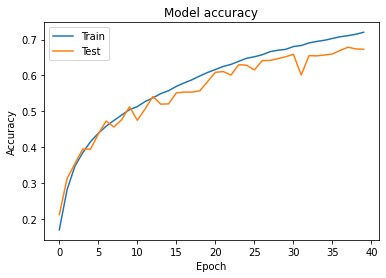

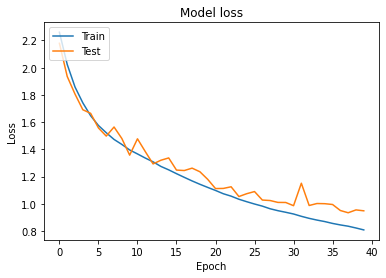

In [6]:
with tf.device('/gpu:0'):
    model = build_model()
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=SGD(lr=0.01), metrics=['accuracy'])

    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=40,
              verbose=1,
              validation_data=(x_test, y_test))

    score = model.evaluate(x_test, y_test, verbose=0)


# Show the learning curve
def draw_curve(score, history):
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

draw_curve(score, history)

# Data Augmentation
Deep neural networks benefit from large amounts of training data. This can be expensive to collect. A cost effective alternative is **Data Augmentation** where we use simple techniques such as croping, rotating, fliping, ...  to generate new versions of existing training data points. 


<font color='red'>Task: Look at the different options for image data augmentation (https://keras.io/api/layers/preprocessing_layers/image_augmentation/). What augmentations make sense for our use case ? Experiment with them to see if you can increase the performance of the model </font>

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/40
391/391 [==============================] - 9s 20ms/step - loss: 2.2527 - accuracy: 0.1621 - val_loss: 2.1692 - val_accuracy: 0.2043
Epoch 2/40
391/391 [==============================] - 7s 18ms/step - loss: 2.0755 - accuracy: 0.2472 - val_loss: 1.9695 - val_accuracy: 0.2803
Epoch 3/40
391/391 [==============================] - 7s 17ms/step - loss: 1.9710 - accuracy: 0.2966 - val_loss: 1.9080 - val_accuracy: 0.3347
Epoch 4/40
391/391 [==============================] - 7s 17ms/step - loss: 1.8869 - accuracy: 0.3315 - val_loss: 1.8045 - val_accuracy: 0.3518
Epoch 5/40
391/391 [==============================] - 7s 17ms/step - loss: 1.8016 - accuracy: 0.3619 - val_loss: 1.6984 - val_accuracy: 0.4036
Epoch 6/40
391/391 [==============================] - 7s 17ms/step - loss: 1.7340 - accuracy: 0.3807 - val_loss: 1.6268 - val_accuracy: 0.4251
Epoch 7/40
391/391 [==============================] - 7s 17ms/step - loss: 1.6686 - accuracy: 0.4071 - val_loss: 1.5578 - val_accuracy: 0.4433

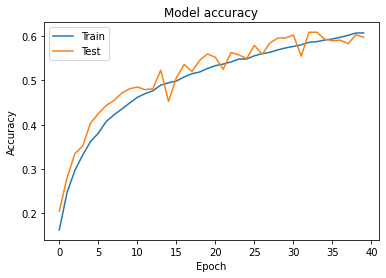

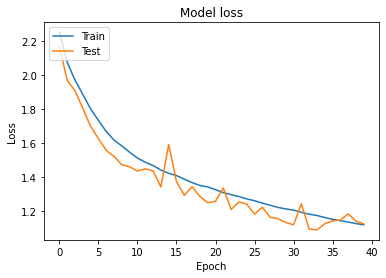

In [7]:
model = Sequential()
...#add data augmentation into your model, add into your model
model.add(layers.RandomFlip(mode="horizontal"))
model.add(layers.RandomZoom(height_factor=(-0.1, 0.1)))
model.add(layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)))
model.add(layers.RandomContrast(factor=0.1))

model.add(Conv2D(32, kernel_size=(3, 3), padding="same", activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))


with tf.device('/gpu:0'):
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=SGD(lr=0.01), metrics=['accuracy'])

    history_da = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=40,
              verbose=1,
              validation_data=(x_test, y_test))

    score_da = model.evaluate(x_test, y_test, verbose=0)
    print(score_da)
    
draw_curve(score_da, history_da)

<font color='red'>Task: Observe the training curves. Do you see a difference in the relationship between train and validation loss ? What could this indicate ? Was it a good idea to stop training after 40 epochs ? </font>

# Batch Normalization
Batch normalization makes sure that the output of a layer has a mean of around zero and a standard deviation of about one. This often makes it easier for the model to train. It is unclear why exactly this is the case. 
<img style="float:left, width=100" src="images/BN.png"/>

<font color='red'>Task: Add batch normalize layers to your model, after each convolutional layer.</font>



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/40
391/391 [==============================] - 7s 17ms/step - loss: 1.6024 - accuracy: 0.4377 - val_loss: 2.2870 - val_accuracy: 0.1694
Epoch 2/40
391/391 [==============================] - 6s 16ms/step - loss: 1.2694 - accuracy: 0.5503 - val_loss: 1.3001 - val_accuracy: 0.5354
Epoch 3/40
391/391 [==============================] - 6s 16ms/step - loss: 1.1306 - accuracy: 0.6023 - val_loss: 1.3845 - val_accuracy: 0.5189
Epoch 4/40
391/391 [==============================] - 6s 16ms/step - loss: 1.0300 - accuracy: 0.6398 - val_loss: 1.8422 - val_accuracy: 0.4394
Epoch 5/40
391/391 [==============================] - 6s 16ms/step - loss: 0.9524 - accuracy: 0.6666 - val_loss: 1.2026 - val_accuracy: 0.5739
Epoch 6/40
391/391 [==============================] - 6s 16ms/step - loss: 0.8965 - accuracy: 0.6871 - val_loss: 1.4274 - val_accuracy: 0.5317
Epoch 7/40
391/391 [==============================] - 6s 16ms/step - loss: 0.8447 - accuracy: 0.7053 - val_loss: 1.3488 - val_accuracy: 0.5588

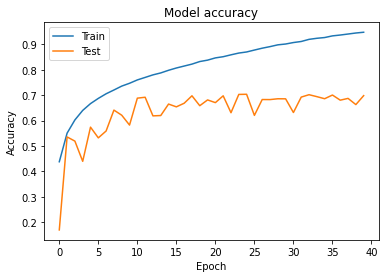

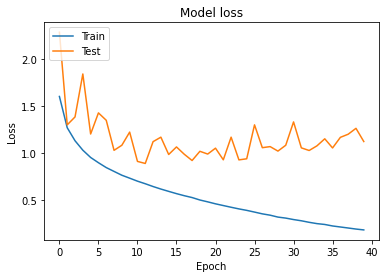

In [8]:
model = Sequential()
...#add batch normlaization layer to your model
model.add(Conv2D(32, kernel_size=(3, 3), padding="same", activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))

...#train with gpu
with tf.device('/gpu:0'):
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=SGD(lr=0.01), metrics=['accuracy'])

    history_bn = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=40,
              verbose=1,
              validation_data=(x_test, y_test))

    score_bn = model.evaluate(x_test, y_test, verbose=0)
    print(score_bn)
    
draw_curve(score_bn, history_bn)

<font color='red'>Task: Investigate the training curves. What would you suggest as a next step ?
</font>
---



# Feature Map Visualization
Visualizing the feature maps of a trained model helps us to better interpret the results and understand our model. 
There are several ways to visualize the feature maps. 
One of them is *Class Activation Map*, it visualizes the region where the model focuses on to make a prediction for a certain input.

<img style="float:left, width=100" src="images/CAM.png"/>

<br/>

Source: https://arxiv.org/abs/1512.04150

Extension: https://github.com/utkuozbulak/pytorch-cnn-visualizations

Reference: https://keras.io/examples/vision/grad_cam/, 


<font color='red'>Task: Visualize the feature maps of trained model using provided functions. </font> 

In [9]:
from IPython.display import Image, display
import matplotlib.cm as cm
import numpy as np

def get_img_array(img_path, size):
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img, heatmap, alpha=0.1):
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    return superimposed_img

Prepare the data for heatmap visualization.

Image Category: 2
Predicted Result: 2


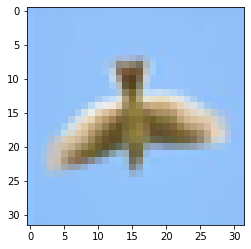

In [10]:
# Set up ONE input image from the dataset. The input image must have the same shape as the model input (1, 32, 32, 3)
idx = 9876
img = np.expand_dims(x_train[idx], axis=0)

#Run prediction to see if the model managed to identify the object.
preds = model.predict(img)[0]
print("Image Category:", np.argmax(y_train[idx]))
print("Predicted Result:", np.argmax(preds))

plt.imshow((img[0] * 255).astype(np.uint8))
plt.show()

<font color='red'>Task: Try different layer of the model and see its visualization.</font> 

In [11]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                      

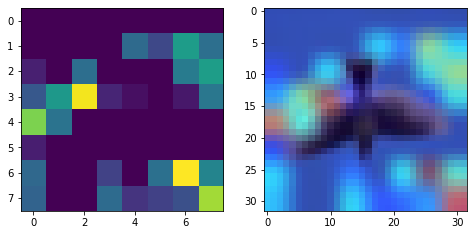

In [12]:
...#Pick a convolution layer to generate the heatmap.
conv_layer_name = "batch_normalization_2"

...#Generate the activation heatmap using the functions provided in the previous cells.
heatmap = make_gradcam_heatmap(img, model, conv_layer_name)

# Display heatmap
fig = plt.figure(figsize=(8, 4))
fig.add_subplot(1, 2, 1)
plt.imshow(heatmap)
fig.add_subplot(1, 2, 2)

...#Generate the superimposed visualization using the provided functions.
heat_img = save_and_display_gradcam(img[0]*255, heatmap, alpha=0.9)
plt.imshow(heat_img)
plt.show()

The heatmap generated by Grad-CAM shows the salient region of an image. 
The colour red indicates that the model considers this region is crucial to classify the image.
The colour blue indicates that these region are less important to the task.

# Transfer Learning
Training a model from scratch requires a large amount of training data and compute power. A common technique to avoid this is to use transfer learning. Here we finteune a pretrained model for a new task. We simply download a trained model and change some of the layer to fit our task. Even though the intital model was trained for a different task, the features it has learned (edges, color transitions) might also be useful for other tasks.

We will use a model that was pretrained on the CIFAR100 dataset. This is similar to CIFAR10 but contains 100 classes instead of 10.

<img style="float:left, width=450" src="images/TL.jpg"/>


Reference: https://github.com/geifmany/cifar-vgg

In [21]:
from google.colab import files
uploaded = files.upload()

Saving vgg16.py to vgg16.py


In [22]:
from google.colab import files
uploaded = files.upload()

Saving cifar100vgg.h5 to cifar100vgg.h5


In [23]:
from vgg16 import cifar100vgg # Make sure to upload the vgg16.py file to colab 

model_pre = cifar100vgg('cifar100vgg.h5').model # Make sure to upload the cifar100vgg.h5 file to colab 

model_pre.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 activation (Activation)     (None, 32, 32, 64)        0         
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 activation_1 (Activation)   (None, 32, 32, 64)        0         
                                                      

<font color='red'>Task: Make a new model, copy all layers except for the last six from the pretrained model and finetune it on the cifar10 dataset
.</font> 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/10
391/391 [==============================] - 63s 150ms/step - loss: 1.2918 - accuracy: 0.7632 - val_loss: 1.2628 - val_accuracy: 0.7797
Epoch 2/10
391/391 [==============================] - 56s 144ms/step - loss: 1.0448 - accuracy: 0.8436 - val_loss: 1.4449 - val_accuracy: 0.7162
Epoch 3/10
391/391 [==============================] - 56s 144ms/step - loss: 0.9549 - accuracy: 0.8707 - val_loss: 1.1136 - val_accuracy: 0.8270
Epoch 4/10
391/391 [==============================] - 56s 145ms/step - loss: 0.9015 - accuracy: 0.8849 - val_loss: 1.1934 - val_accuracy: 0.7939
Epoch 5/10
391/391 [==============================] - 57s 145ms/step - loss: 0.8619 - accuracy: 0.8959 - val_loss: 1.0381 - val_accuracy: 0.8429
Epoch 6/10
391/391 [==============================] - 57s 145ms/step - loss: 0.8325 - accuracy: 0.9040 - val_loss: 0.9535 - val_accuracy: 0.8654
Epoch 7/10
391/391 [==============================] - 56s 144ms/step - loss: 0.8049 - accuracy: 0.9107 - val_loss: 0.9669 - val_ac

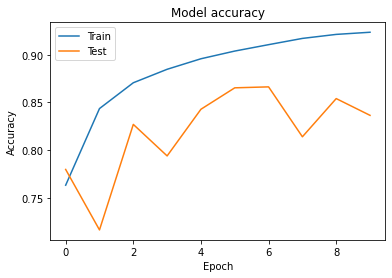

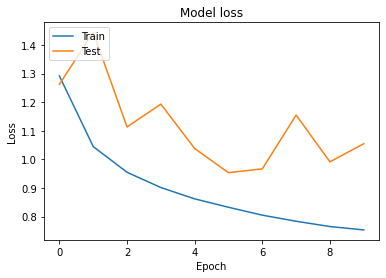

In [24]:
model = Sequential()


for layer in model_pre.layers[:-8]:
    model.add(layer)
    
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))

with tf.device('/gpu:0'):
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=SGD(lr=0.1), metrics=['accuracy'])

    history_10 = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=10,
              verbose=1,
              validation_data=(x_test, y_test))

    score_10 = model.evaluate(x_test, y_test, verbose=0)
    
draw_curve(score_10, history_10)